## Project Summary and Notes

This project is focused on a few key elements of practice and exploration:
* Usage of Pandas and Seaborn for data manipulation & visualization
* Basic EDA of Time Series data on hourly energy consumption from 2002-2019
* Application of XGBoost and ScikitLearn for Machine Learning-based modeling and prediction of future data

In [45]:
# Data wrangling tools
import pandas as pd
import numpy as np

# Plotting tools and presets
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette()
mpl.rcParams['axes.grid'] = True
mpl.rcParams['figure.edgecolor'] = 'none'
plt.style.use('ggplot')

# Modeling and insight tools
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# Organization Tools
import os
import shutil

## Reading/Indexing Data + Preliminary Viz

                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0
                     PJME_MW
Datetime                    
2018-01-01 20:00:00  44284.0
2018-01-01 21:00:00  43751.0
2018-01-01 22:00:00  42402.0
2018-01-01 23:00:00  40164.0
2018-01-02 00:00:00  38608.0


<AxesSubplot:title={'center':'PJME Energy Use [mW]'}, xlabel='Datetime'>

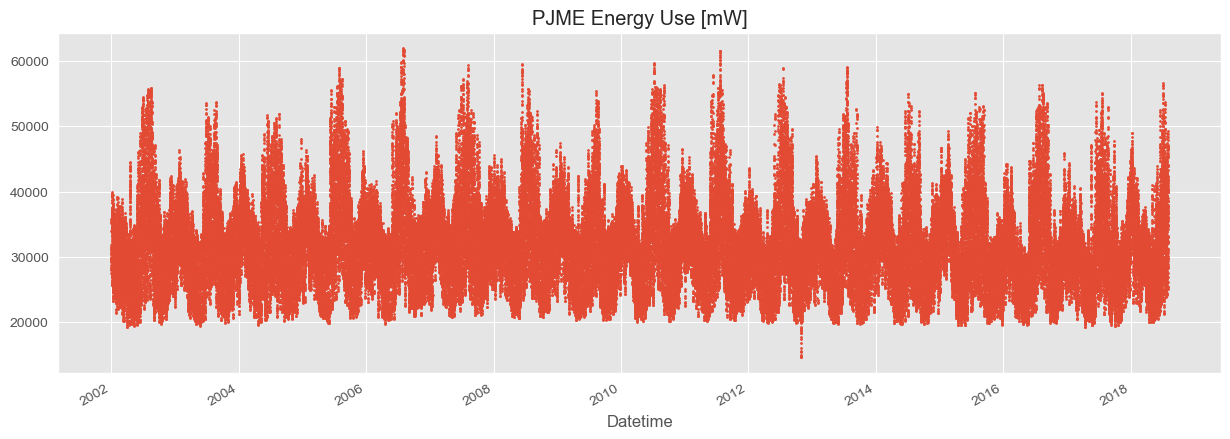

In [46]:
df = pd.read_csv('PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)
print(df.head())
print(df.tail())

plot_prelim = plt.figure(1)
df['PJME_MW'].plot(style='.',
                   figsize=(15,5),
                   ms=2,
                   title='PJME Energy Use [mW]')


Data is visually very consistent in both stationarity and seasonality, we will forego analysis of this.
Data appears to have notable outliers in the area around the end of 2013, worth investigating as follows.

## Outlier Investigation and Removal

<AxesSubplot:ylabel='Frequency'>

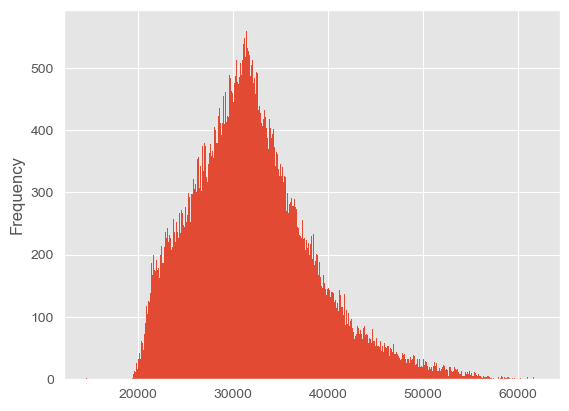

In [47]:
# Histogram for further exploration of data spread and frequencies
plot_allhist = plt.figure(2)
df['PJME_MW'].plot(kind='hist',
                   bins=1000,
                   edgecolor='none')

The outliers are not frequent, but those that exist could be a nuisance as far as training our model goes.
Viz so far indicates values fall below 20000mW somewhat regularly, though outliers appear to be well below this.
We will continue our investigation around this 20000mW value as a heuristic.

<AxesSubplot:xlabel='Datetime'>

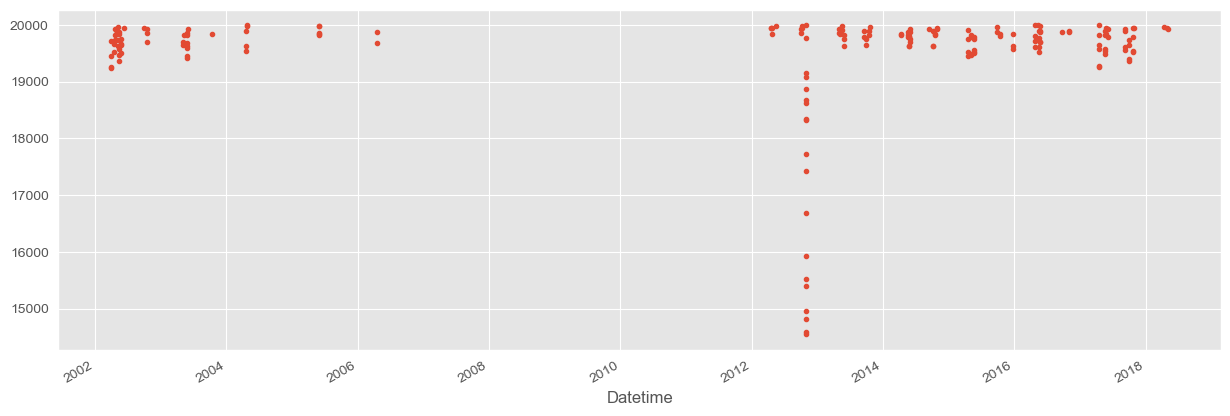

In [48]:
plot_outliers = plt.figure(3)
outlier_df = df.query('PJME_MW < 20000')
outlier_df['PJME_MW'].plot(style='.',
                           figsize=(15,5))

Viz indicates a good cutoff for outlier removal here would be around 19000.
Let's do another quick viz to see if we can confirm this.

<AxesSubplot:xlabel='Datetime'>

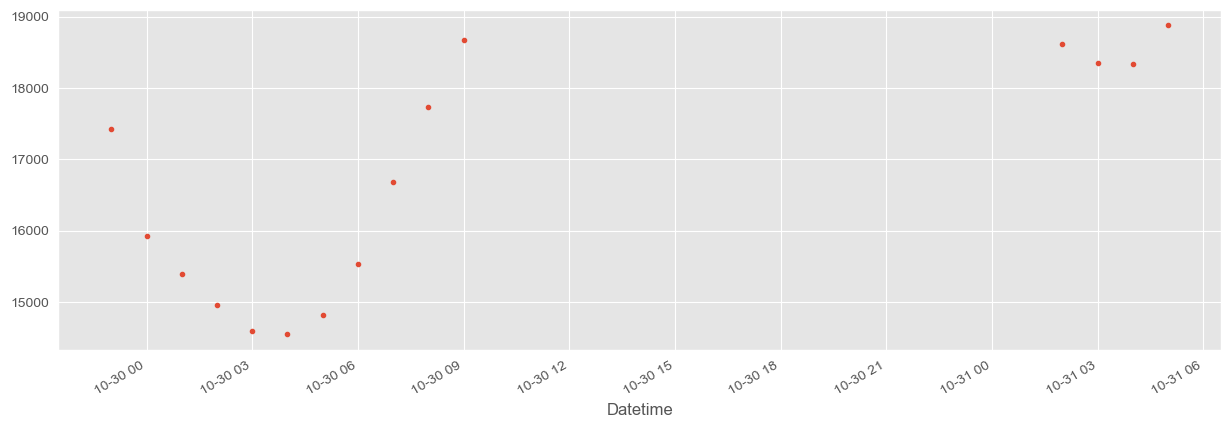

In [49]:
plot_cutoff = plt.figure(4)
cutoff_df = df.query('PJME_MW < 19000')
cutoff_df['PJME_MW'].plot(style='.',
                          figsize=(15,5))

All values below 19000mW are within the span of about a single day.
This is a good indicator we can go ahead and use 19000 as our outlier cutoff in moving forward with our analysis.
A quick df.query() below to achieve that.

In [50]:
df = df.query('PJME_MW > 19000').copy()

## Feature and Lag Creation + Viz

With the few notable outliers removed, we can move ahead to create and train a model.
Here we create some "standard" features for Time-Series-style data (day/week/month),
and engineer various Lag features in order to improve future predictive performance.

In [51]:
def create_features(df):
    """
    Create time series features based on DataFrame index.
    :param df: input 'df' containing time series data
    :return: input 'df' with new indexing features added
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year

    return df

df = create_features(df)

def create_lags(df):
    """
    Create Lag features (1yr, 2yr, 3yr).
    Multiples of '364' in order to lag back to same "day of year"
    :param df: input 'df' containing time series data
    :return: input 'df' with new lag features added
    """
    #TODO: .to_dict() reasoning
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)

    return df

df = create_lags(df)
print(df.tail())    # Check on the newly-created features 

                     PJME_MW  hour  dayofweek  dayofmonth  dayofyear  month  \
Datetime                                                                      
2018-01-01 20:00:00  44284.0    20          0           1          1      1   
2018-01-01 21:00:00  43751.0    21          0           1          1      1   
2018-01-01 22:00:00  42402.0    22          0           1          1      1   
2018-01-01 23:00:00  40164.0    23          0           1          1      1   
2018-01-02 00:00:00  38608.0     0          1           2          2      1   

                     quarter  year     lag1     lag2     lag3  
Datetime                                                       
2018-01-01 20:00:00        1  2018  34600.0  41772.0  40740.0  
2018-01-01 21:00:00        1  2018  33674.0  41393.0  40049.0  
2018-01-01 22:00:00        1  2018  32035.0  40092.0  38473.0  
2018-01-01 23:00:00        1  2018  29870.0  37911.0  35962.0  
2018-01-02 00:00:00        1  2018  27771.0  35931.0  33680.0 

# Visualization of Non-Lag Features

Here we take a basic look at the trends across our newly-added features,
confirming what we might expect from highly-seasonal data such as those we are
working with and visualizing some characteristics such as center and spread.

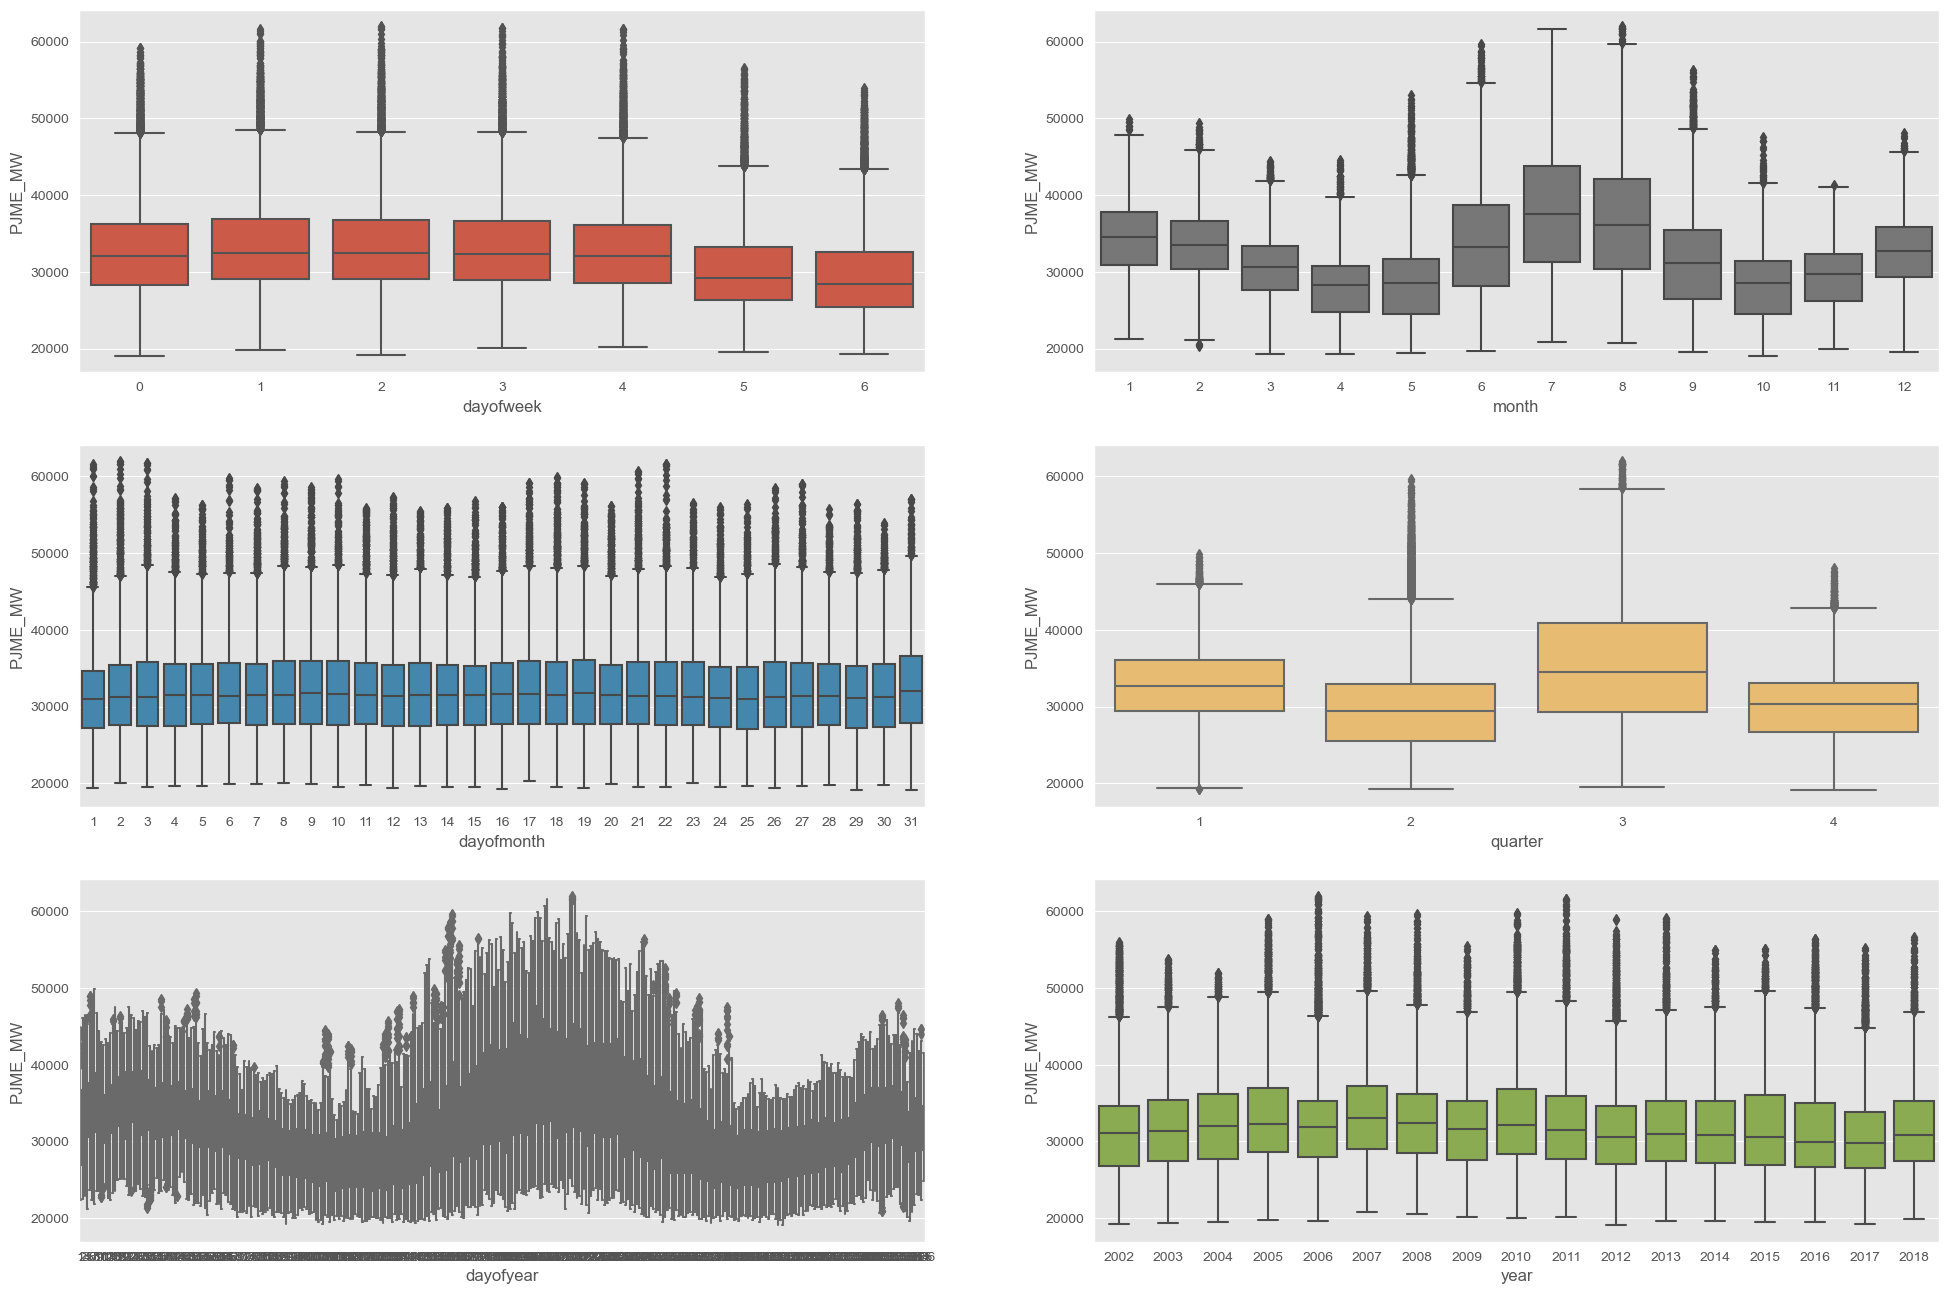

In [52]:
plot_nonlag_features, axes = plt.subplots(3, 2, figsize=(24, 16))

FEATURES_NOLAG = ['dayofweek', 'dayofmonth', 'dayofyear',
              'month', 'quarter', 'year']

for i in range(len(FEATURES_NOLAG)):
    sns.boxplot(data=df, x=FEATURES_NOLAG[i], y='PJME_MW',
                color=palette[i], ax=axes[i%3, i//3])

### Model Training and Cross-Validation

Initiating Cross-validation Fold #0
Train/Test split set to 2013-08-02 22:00:00 and 2013-08-03 23:00:00
      according to TimeSeriesSplit() parameters
Adding data split to viz in 'PJME_crossvalid.png'
Creating regressive model and fitting...
[0]	validation_0-rmse:32732.49608	validation_1-rmse:31956.60163
[100]	validation_0-rmse:12532.64369	validation_1-rmse:11906.14134
[200]	validation_0-rmse:5747.92495	validation_1-rmse:5359.26490
[300]	validation_0-rmse:3872.45680	validation_1-rmse:3900.22955
[400]	validation_0-rmse:3434.17801	validation_1-rmse:3760.50563
[448]	validation_0-rmse:3361.98735	validation_1-rmse:3764.85714
Predicted values stored in 'preds' list,
    RMS prediction error stored in 'scores' list

Initiating Cross-validation Fold #1
Train/Test split set to 2014-08-03 00:00:00 and 2014-08-04 01:00:00
      according to TimeSeriesSplit() parameters
Adding data split to viz in 'PJME_crossvalid.png'
Creating regressive model and fitting...
[0]	validation_0-rmse:32672.16678	val

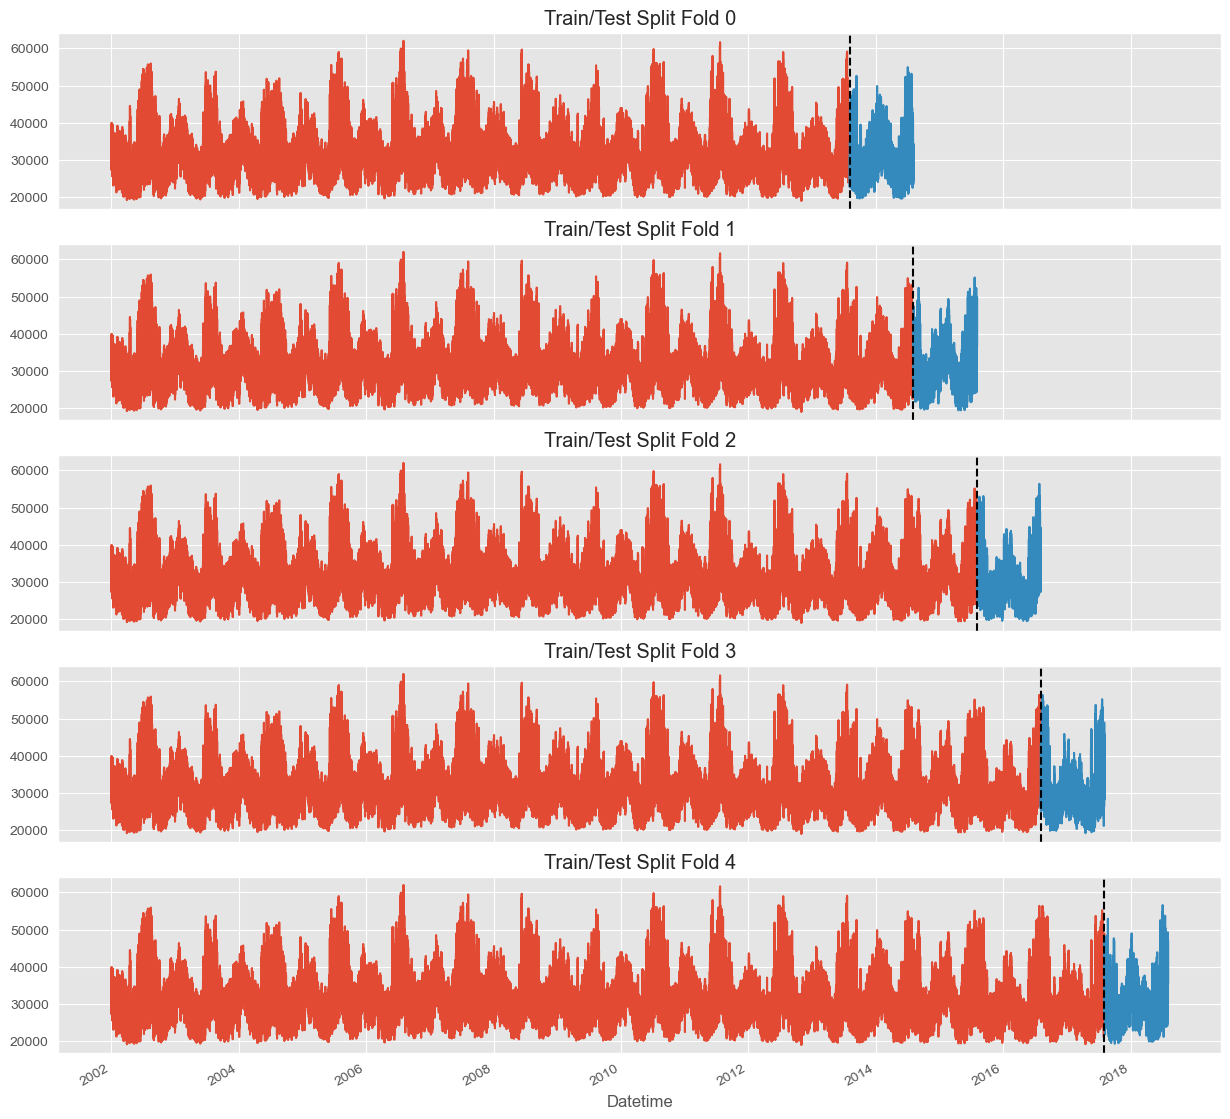

In [53]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365, gap=24)
df = df.sort_index()

plot_crossvalid, axis = plt.subplots(5, 1, figsize=(15,15), sharex=True)

FEATURES_LAG = ['hour', 'dayofweek', 'dayofmonth', 'dayofyear',
                'month', 'quarter', 'year',
                'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

fold = 0
preds = []
scores = []
for train_idx, test_idx in tss.split(df):
    print(f'Initiating Cross-validation Fold #{fold}')
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    print(f'''Train/Test split set to {train.index.max()} and {test.index.min()}
      according to TimeSeriesSplit() parameters''')

    print("Adding data split to viz in 'PJME_crossvalid.png'")
    train['PJME_MW'].plot(ax=axis[fold],
                          label='Training Set',
                          ms=2,
                          title=f'Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axis[fold],
                         label='Test Set',
                         ms=2)
    axis[fold].axvline(test.index.min(), color='black', ls='--')

    # Defining Train and Test set Features & Target
    x_train = train[FEATURES_LAG]
    y_train = train[TARGET]
    x_test = test[FEATURES_LAG]
    y_test = test[TARGET]

    print(f'Creating regressive model and fitting...')
    regression = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                                  n_estimators=1000,
                                  early_stopping_rounds=50,
                                  objective='reg:squarederror',
                                  max_depth=3,
                                  learning_rate=0.01)
    regression.fit(x_train, y_train,
                   eval_set=[(x_train, y_train), (x_test, y_test)],
                   verbose=100)

    y_pred = regression.predict(x_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    print(f'''Predicted values stored in 'preds' list,
    RMS prediction error stored in 'scores' list\n''')

    fold += 1

print(f'''Mean RMS prediction error across folds {np.mean(scores):0.3f}
Fold RMS prediction errors (by fold): {scores}\n''')

# ## A brief rundown of "generalized" Model Creation structure w/ XGBoost
#
# train = create_features(train)
# test = create_features(test)
#
# x_train = train[FEATURES]
# y_train = train[TARGET]
#
# x_test = test[FEATURES]
# y_test = test[TARGET]
#
# reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)
# reg.fit(x_train, y_train,
#         eval_set=[(x_train, y_train), (x_test, y_test)],
#         verbose=100)

With our model created, trained, and tested through multiple rounds of cross-validation,
we can move to visualize which features it considers most important in modeling the data.
This provides valuable insight into the effects of characteristics like "Time of Day" and
"Day of Week" on the expected amount of energy consumption.

## Feature Importance Comparison

<AxesSubplot:title={'center':'Feature Importance'}>

<Figure size 640x480 with 0 Axes>

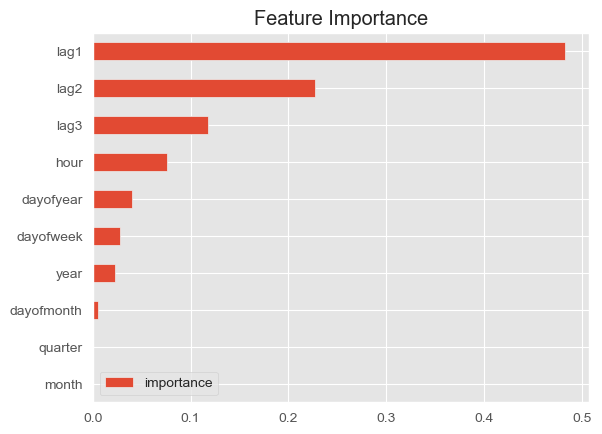

In [54]:
fi = pd.DataFrame(data=regression.feature_importances_,
                  index=regression.feature_names_in_,
                  columns=['importance'])

plot_featureimp = plt.figure(5)
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')

Interestingly, the 3 most powerful predictors of energy consumption at a given point of time
in our data are the energy consumption values from the 1, 2, and 3 years prior to that point.
These are followed by the Hour of the current point in time, which one might reasonably expect
as power consumption ties very closely to the waking/working hours of a given population.

## Forecasting New Year on Full Data

In order to best apply our model here, we want to retrain on the full span of data.
As such, we will run XGBRegressor once again as follows, using the 'FEATURES_LAG'
list of features we've already created.

In [55]:
x_full = df[FEATURES_LAG]
y_full = df[TARGET]

full_reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                            n_estimators=500,
                            objective='reg:squarederror',
                            max_depth=3,
                            learning_rate=0.01)
full_reg.fit(x_full, y_full,
             eval_set=[(x_full, y_full)],
             verbose=100)

[0]	validation_0-rmse:32403.88991
[100]	validation_0-rmse:12426.83220
[200]	validation_0-rmse:5751.73275
[300]	validation_0-rmse:3971.53256
[400]	validation_0-rmse:3571.21833
[499]	validation_0-rmse:3456.76877


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Creating DataFrame for Future Data

First, we need to identify the "real maximum date" from our data, then
set our 'date_range' limit for our new DataFrame out to 1 year past that.

Using df.index.max(), we find the "real maximum date" is '2018-08-03'.
Knowing this, we'll set our range out to '2019-08-03'.

In [56]:
future = pd.date_range('2018-08-03', '2019-08-03', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_w_future = pd.concat([df, future_df])

df_w_future = create_lags(create_features(df_w_future))

future_w_features = df_w_future.query('isFuture').copy()

future_w_features

,PJME_MW,hour,dayofweek,dayofmonth,dayofyear,month,quarter,year,lag1,lag2,lag3,isFuture
2018-08-03 00:00:00,NaN,0,4,3,215,8,3,2018,33539.0,32094.0,31695.0,True
2018-08-03 01:00:00,NaN,1,4,3,215,8,3,2018,30781.0,29503.0,29128.0,True
2018-08-03 02:00:00,NaN,2,4,3,215,8,3,2018,29015.0,27712.0,27373.0,True
2018-08-03 03:00:00,NaN,3,4,3,215,8,3,2018,27884.0,26535.0,26233.0,True
2018-08-03 04:00:00,NaN,4,4,3,215,8,3,2018,27223.0,25870.0,25643.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-02 20:00:00,NaN,20,4,2,214,8,3,2019,NaN,43606.0,40513.0,True
2019-08-02 21:00:00,NaN,21,4,2,214,8,3,2019,NaN,41863.0,39840.0,True
2019-08-02 22:00:00,NaN,22,4,2,214,8,3,2019,NaN,40005.0,38664.0,True
2019-08-02 23:00:00,NaN,23,4,2,214,8,3,2019,NaN,37174.0,36125.0,True


## Forecasting

With all the work we've done on our model, we can now use it to predict values out for the next year, from 2018-08-04 to 2019-08-03.

2018-08-03 00:00:00    30747.998047
2018-08-03 01:00:00    28575.041016
2018-08-03 02:00:00    27978.013672
2018-08-03 03:00:00    27365.339844
2018-08-03 04:00:00    26971.216797
                           ...     
2019-08-02 20:00:00    39220.527344
2019-08-02 21:00:00    39072.988281
2019-08-02 22:00:00    38276.277344
2019-08-02 23:00:00    37195.320312
2019-08-03 00:00:00    29884.779297
Name: pred, Length: 8761, dtype: float32


<AxesSubplot:title={'center':'Predictions w/ All Features (1yr)'}>

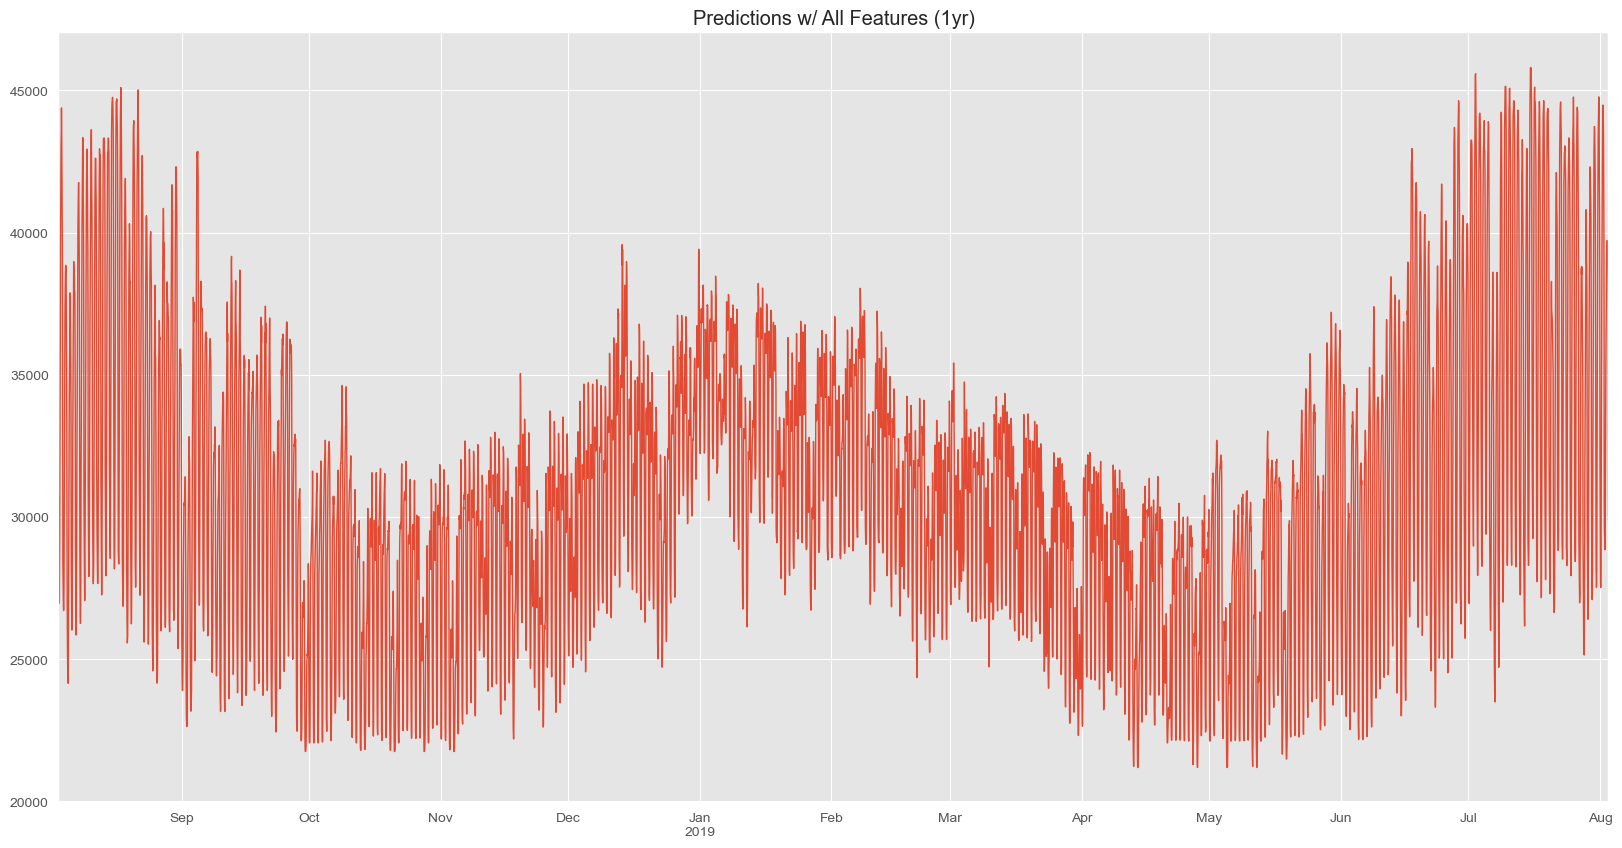

In [57]:
future_w_features['pred'] = full_reg.predict(future_w_features[FEATURES_LAG])
print(future_w_features['pred'])

plot_future = plt.figure(10)
future_w_features['pred'].plot(figsize=(20, 10),
                               ms=1, lw=1,
                               title='Predictions w/ All Features (1yr)')

## Saving Model & Organizing Outputs

In [59]:
def assets_to_new_dir(new_dir):

    if (new_dir not in os.getcwd()) and (new_dir not in os.listdir()):
        os.mkdir(new_dir)
        
        plot_prelim.savefig('PJME_hourly_all.png')
        plot_allhist.savefig('PJME_hourly_hist.png')
        plot_outliers.savefig('PJME_hourly_outliers.png')
        plot_cutoff.savefig('PJME_hourly_cutoff.png')
        plot_nonlag_features.savefig('PJME_nonlag_features.png')
        plot_crossvalid.savefig('PJME_crossvalid.png')
        plot_featureimp.savefig('PJME_featureimp.png')
        plot_future.savefig('PJME_predictions_1yr.png')
        
        full_reg.save_model('gh_model.json')
        
        assets = [i for i in os.listdir() if '.png' in i.lower()]
        assets.append('gh_model.json')
    else:
        print("Organized output already exists. Check for directory 'PJME_analysis_predictions' in cwd")
        return None

    for asset in assets:
        shutil.move(asset, new_dir)

if __name__ == '__main__':
    new_dir_name = 'PJME_analysis_predictions'
    assets_to_new_dir(new_dir_name)

Organized output already exists. Check for directory 'PJME_analysis_predictions' in cwd
